# Table of Contents
- [Problem Statement](##problem-statement)
- [Action Plan](#action-Plan)
- [Dataset Overview](##dataset-overview)
- [Data Inspection](##data-inspection)
- [Data Preprocessing](##data-preprocessing)
- [Data Visualization](##Data-visualization)
- [Building CNN](##building-cnn)
- [Evaluation](###evaluation)
- [Using VGG16](##using-vgg16)
- [Training on Custom Data](###training-on-custom-data)
- [Results on Unseen Data](###results-on-unseen-data)
- [Confusion matrix](###confusion-matrix)
- [Classification report](###classification-report)
- [Deploying our Model for prototyping](##deploying-our-model-for-prototyping)

## Problem Statement

AeroCheck Station operates in a remote location where reliable weather data is essential, but infrequent manual checks hinder effective monitoring. This lack of timely information poses challenges for maintaining equipment, such as solar panels and communication systems, which can be impacted by changing weather conditions.

## Action Plan
To address this issue, we propose integrating an image classifier that analyzes images of the environment and categorizes the weather into five classifications: sunny, rainy, foggy, cloudy, and sunrise. 

- For instance, when the classifier identifies that it is raining, maintenance personnel can be promptly alerted to perform necessary checks on drainage systems and equipment to prevent water damage. 

- Additionally, if the classifier detects foggy conditions, operators can take precautionary measures to ensure that visibility is enhanced around the station. 

- Upon identifying sunrise, maintenance personnel can receive alerts to conduct routine checks on solar panels and other equipment, ensuring optimal functioning throughout the day as sunlight increases.

# Dataset Overview

The dataset features 5 different classes of weather collected different sources from internet. The dataset contains about 1500 labelled images including the validation images.

Images are not of fixed dimensions and the photos are of different sizes. Each image has only one weather category and are saved in separate folder as of the labelled class.

Each image have been rated for the weather condition on a scale of 0 to 4:

0 - cloudy
1 - foggy
2 - rain
3 - shine
4 - sunrise

### Importing Libraries

In [34]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os

# Data Inspection

In [82]:
import os
path="/kaggle/input/weather1test/Wdataset1/Wdataset/train"

# List class directories in the unzipped folder

class_names = os.listdir(path)
print("Class names:", class_names)


Class names: ['cloudy', 'sunrise', 'shine', 'foggy', 'rainy']


In [83]:
subfolder_path = "/kaggle/input/weather1test/Wdataset1/Wdataset/train"

# Counting images in each class to avoid class imbalance

class_counts = {class_name: len(os.listdir(os.path.join(subfolder_path, class_name)))
                for class_name in os.listdir(subfolder_path) if os.path.isdir(os.path.join(subfolder_path, class_name))}
print("Image counts per class:", class_counts)


Image counts per class: {'cloudy': 256, 'sunrise': 304, 'shine': 250, 'foggy': 256, 'rainy': 256}


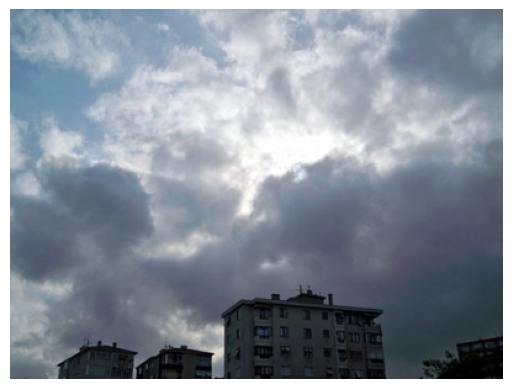

In [84]:
from PIL import Image
# Open an image file
img = Image.open('/kaggle/input/weather1test/Wdataset1/Wdataset/train/cloudy/cloudy2.jpg')

# Get the size of the image
width, height = img.size

plt.imshow(img)
plt.axis('off')  # Turn off the axis
plt.show()

# Data Preprocessing

In [6]:
# Creating ImageDataGen
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)


In [7]:
# Define paths to your training and validation directories
train_dir = '/kaggle/input/weather1test/Wdataset1/Wdataset/train'  
validation_dir = '/kaggle/input/weather1test/Wdataset1/Wdataset/test'  

In [36]:
# Creating train_generator
train_generator = datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),  # Resize images to this size
    batch_size=32,
    class_mode='sparse',  # Use 'binary' for binary classification
    shuffle=True,
    #subset='training'
)
# Print the class indices
print("Training Class Labels: ", train_generator.class_indices)

Found 1322 images belonging to 5 classes.
Training Class Labels:  {'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}


In [35]:
# Creating validation_generator
validation_generator = datagen.flow_from_directory(
    validation_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse',  # Use 'binary' for binary classification
)
# Print the class indices
print("Training Class Labels: ", validation_generator.class_indices)

Found 250 images belonging to 5 classes.
Training Class Labels:  {'cloudy': 0, 'foggy': 1, 'rainy': 2, 'shine': 3, 'sunrise': 4}


# Data Visualization

x (features) shape: (32, 224, 224, 3)
y (labels) shape: (32,)


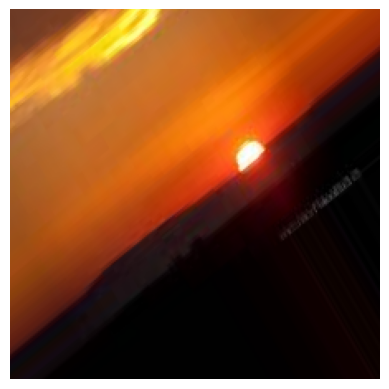

Corresponding label: 4.0


In [13]:
# Get a batch of data
x_batch, y_batch = next(train_generator)

# Display the shape of the features and labels
print(f"x (features) shape: {x_batch.shape}")
print(f"y (labels) shape: {y_batch.shape}")

# Example: Display the first image and its corresponding label

# Display the first image in the batch
plt.imshow(x_batch[0])
plt.axis('off')
plt.show()

# Print the corresponding label
print("Corresponding label:", y_batch[0])


x (features) shape: (32, 224, 224, 3)
y (labels) shape: (32,)


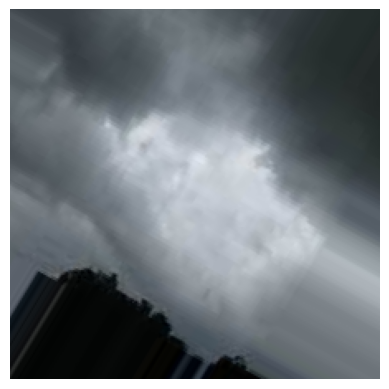

In [37]:
# Get a batch of data
x_batch, y_batch = next(validation_generator)

# Display the shape of the features and labels
print(f"x (features) shape: {x_batch.shape}")
print(f"y (labels) shape: {y_batch.shape}")


# Display the first image in the batch
plt.imshow(x_batch[0])  
plt.axis('off')
plt.show()

# Building a CNN

In [92]:
from keras import layers, models
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization
from keras.optimizers import Adam

# Create the CNN model
model = models.Sequential()

#1st layer
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)))
model.add(layers.MaxPooling2D((2, 2)))

# 2nd convolutional layer
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(layers.Dropout(0.6))
model.add(layers.MaxPooling2D((2, 2)))



# Flatten the output
model.add(layers.Flatten())

# Add 1st Dense layer
model.add(layers.Dense(100, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.30))

# Add 2nd Dense layer
model.add(layers.Dense(100, activation='relu'))  # Hidden layer
model.add(layers.Dropout(0.6))

# output layer
model.add(layers.Dense(5, activation='softmax'))

# Compile the model
model.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Set up early stopping
early_stopping = EarlyStopping(
    monitor='val_loss',  # or 'val_accuracy'
    patience=8,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restore model weights from the epoch with the best validation loss
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [93]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 109, 109, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 186624)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 100)            │    18,662,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 100)            │        10,100 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 100)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           505 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,692,753 (71.31 MB)

 Trainable params: 18,692,625 (71.31 MB)

 Non-trainable params: 128 (512.00 B)

In [94]:
# Fit the model
#history = model.fit(train_ds, validation_data=val_ds, epochs=15,callbacks=[early_stopping])
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=15,  # You can adjust this as needed
    callbacks=[early_stopping]  # Include early stopping
)



Epoch 1/15


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1727801624.600203      92 service.cc:145] XLA service 0x78ef4000df30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727801624.600265      92 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


 1/41 ━━━━━━━━━━━━━━━━━━━━ 9:06 14s/step - accuracy: 0.0938 - loss: 2.9910

I0000 00:00:1727801632.197249      92 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


41/41 ━━━━━━━━━━━━━━━━━━━━ 40s 651ms/step - accuracy: 0.2881 - loss: 12.5333 - val_accuracy: 0.2277 - val_loss: 4.3083
Epoch 2/15
 1/41 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.3750 - loss: 1.5343

/opt/conda/lib/python3.10/contextlib.py:153: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - accuracy: 0.3750 - loss: 1.5343 - val_accuracy: 0.1154 - val_loss: 4.9999
Epoch 3/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 453ms/step - accuracy: 0.4196 - loss: 1.4148 - val_accuracy: 0.2098 - val_loss: 7.8887
Epoch 4/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4375 - loss: 1.4105 - val_accuracy: 0.2692 - val_loss: 7.4736
Epoch 5/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 439ms/step - accuracy: 0.4382 - loss: 1.3609 - val_accuracy: 0.2232 - val_loss: 9.3484
Epoch 6/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5625 - loss: 1.4076 - val_accuracy: 0.1538 - val_loss: 11.6952
Epoch 7/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 41s 451ms/step - accuracy: 0.5035 - loss: 1.1764 - val_accuracy: 0.2188 - val_loss: 12.7566
Epoch 8/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4688 - loss: 1.2621 - val_accuracy: 0.1923 - val_loss: 12.5653
Epoch 9/15
41/41 ━━━━━━━━━━━━━━━━━━━━ 21s 440ms/step - accuracy: 0.4607 - loss: 1.3033 - val_accuracy: 0.2054 - val_

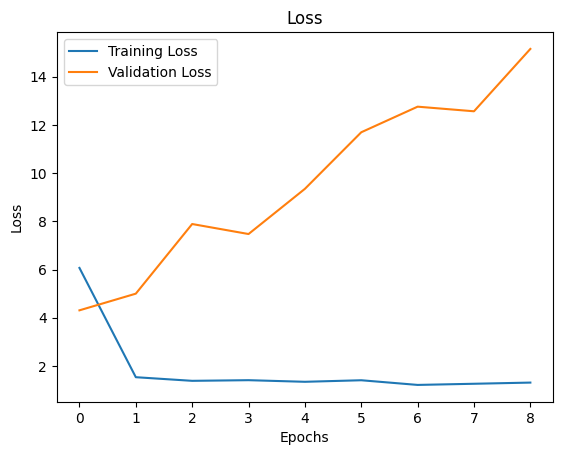

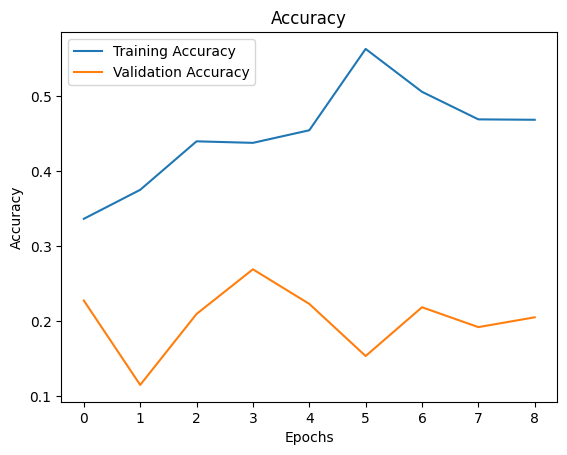

In [95]:
# learning curve
# Plot training & validation loss values
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

## Evaluation

We are getting very less accuracy on traning and validation accuracy. We will import (VGG16) and train it on custom data. 

#classification repot

# Using VGG16

In [19]:
from keras.applications import VGG16
from keras import models, layers
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam

# Load the VGG16 model without the top classification layer
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

# Create the input layer explicitly
inputs = layers.Input(shape=(224, 224, 3))

# Add the VGG16 base model to the functional flow
x = base_model(inputs)  # Pass the input to the base model

# Add custom layers on top of the base model
x = layers.Flatten()(x)  # Flatten the output from VGG16
x = layers.Dense(80, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.2)(x)  # Add dropout for regularization

x = layers.Dense(120, activation='relu')(x)  # Second dense layer
x = layers.BatchNormalization()(x)

outputs = layers.Dense(5, activation='softmax')(x)  # Output layer with softmax


early_stopping = EarlyStopping(
    monitor='val_loss',    # Metric to monitor (could also be 'val_accuracy')
    patience=5,            # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore the weights of the best epoch
)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)


# Create the model using the defined inputs and outputs
model = models.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [20]:
model.summary()

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ (None, 7, 7, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 80)             │     2,007,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 80)             │           320 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 80)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 120)            │         9,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 120)            │           480 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 5)              │           605 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,732,933 (63.83 MB)

 Trainable params: 2,017,845 (7.70 MB)

 Non-trainable params: 14,715,088 (56.13 MB)

## Training on Custom Data

In [21]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // validation_generator.batch_size,
    epochs=25,  # You can adjust this as needed
    callbacks=[early_stopping,reduce_lr]  # Include early stopping
)

Epoch 1/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 28s 512ms/step - accuracy: 0.5831 - loss: 1.1723 - val_accuracy: 0.3036 - val_loss: 2.6370 - learning_rate: 0.0010
Epoch 2/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.7500 - loss: 0.5061 - val_accuracy: 0.3077 - val_loss: 2.7518 - learning_rate: 0.0010
Epoch 3/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 450ms/step - accuracy: 0.8185 - loss: 0.5074 - val_accuracy: 0.4554 - val_loss: 1.5153 - learning_rate: 0.0010
Epoch 4/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.8750 - loss: 0.4765 - val_accuracy: 0.4615 - val_loss: 1.3782 - learning_rate: 0.0010
Epoch 5/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 469ms/step - accuracy: 0.8555 - loss: 0.3899 - val_accuracy: 0.8214 - val_loss: 0.6235 - learning_rate: 0.0010
Epoch 6/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8438 - loss: 0.3333 - val_accuracy: 0.8077 - val_loss: 0.7284 - learning_rate: 0.0010
Epoch 7/25
41/41 ━━━━━━━━━━━━━━━━━━━━ 22s 479ms/step - accuracy: 0.8766 - loss: 0.3791 - v

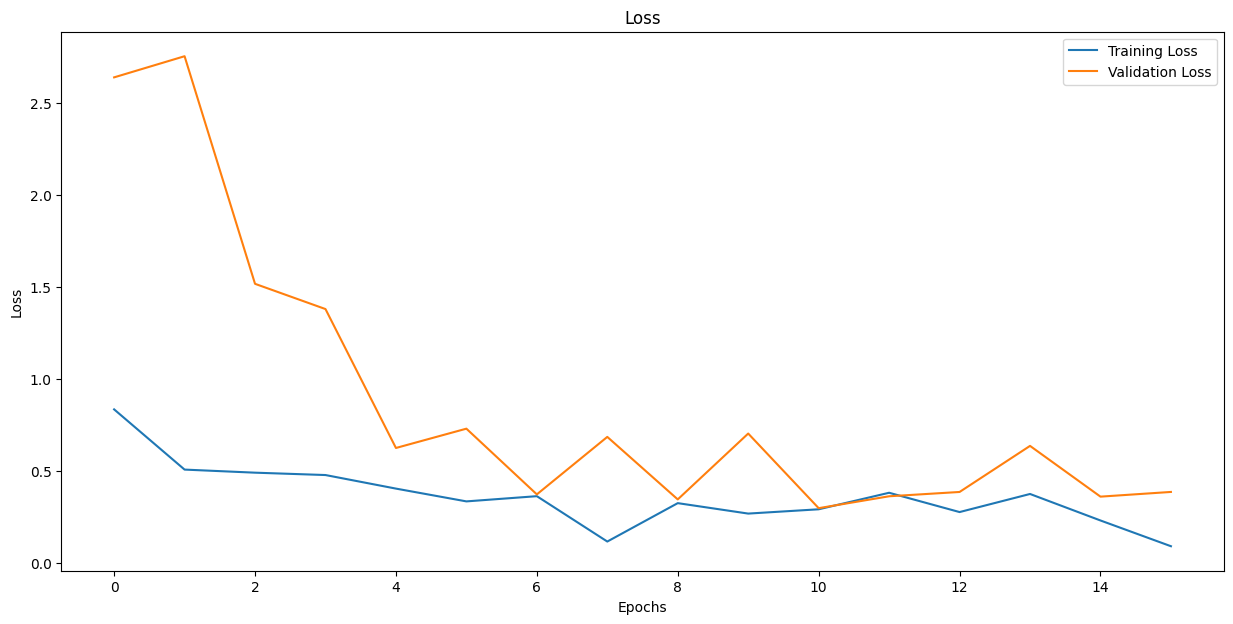

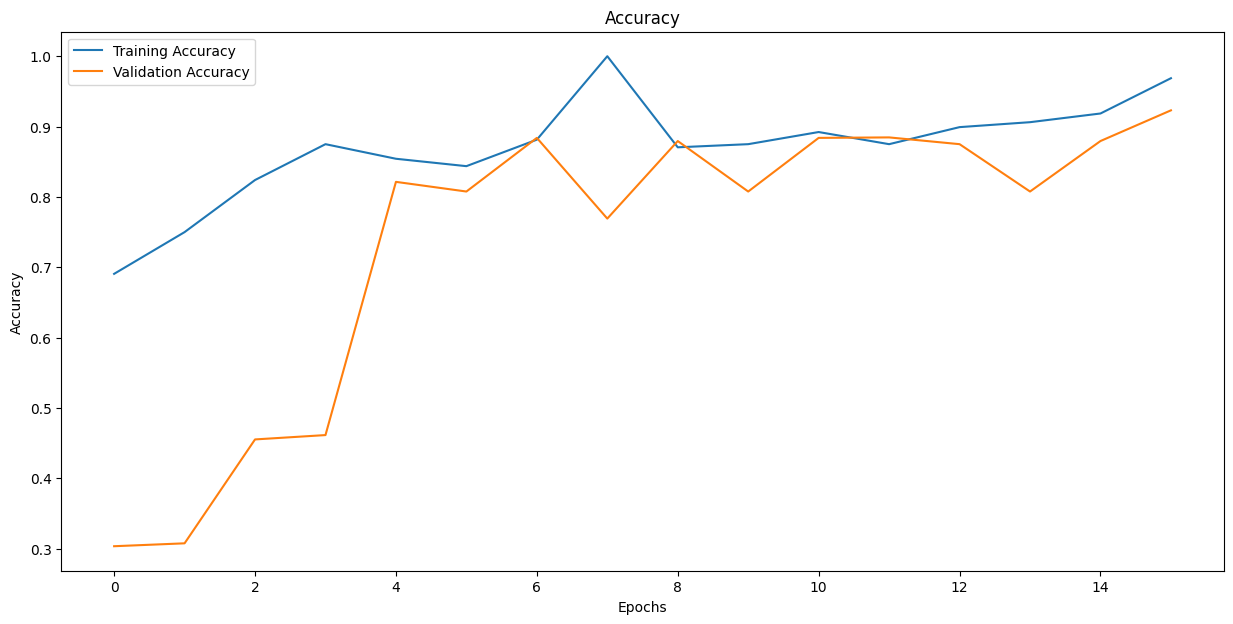

In [22]:
# learning curve
# Plot training & validation loss values
import matplotlib.pyplot as plt
plt.figure(figsize=(15,7))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(15,7))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [23]:
model.save('best_model.h5')

In [29]:
from tensorflow.keras.models import load_model

model_path = '/kaggle/working/best_model.h5'
model = load_model(model_path)


### Creating ImageDataGenerator for Unseen Data

In [30]:
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator


# ImageDataGenerator for testing

test_datagen = ImageDataGenerator(rescale=1./255)  # Rescale the images

# Setting the directory path for test images
test_directory = '/kaggle/input/weather1test/ut1/ut'  # Change this to your actual folder path

test_generator = test_datagen.flow_from_directory(
    test_directory,
    target_size=(224, 224),  # Resize images as needed
    batch_size=16,  # Adjust batch size as needed
    class_mode='sparse'  # Use 'sparse' if your labels are integers, 'categorical' for one-hot encoded labels
)

Found 25 images belonging to 5 classes.


# Results on Unseen Data

In [31]:
# Get predictions for all images in the test_generator
predictions = model.predict(test_generator)

# Get the predicted classes for all images
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_classes = test_generator.classes
print(true_classes)
print(predicted_classes)

# Calculate accuracy by comparing predicted classes with true labels
accuracy = np.mean(predicted_classes == true_classes)

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')


2/2 ━━━━━━━━━━━━━━━━━━━━ 8s 3s/step
[0 0 0 1 1 1 1 2 2 2 2 2 2 3 3 3 3 3 4 4 4 4 4 4 4]
[4 1 0 3 4 2 4 2 3 0 2 3 4 1 2 2 3 3 4 2 4 1 2 0 1]
Accuracy: 28.00%


### Confusion matrix

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step 
Accuracy: 20.00%


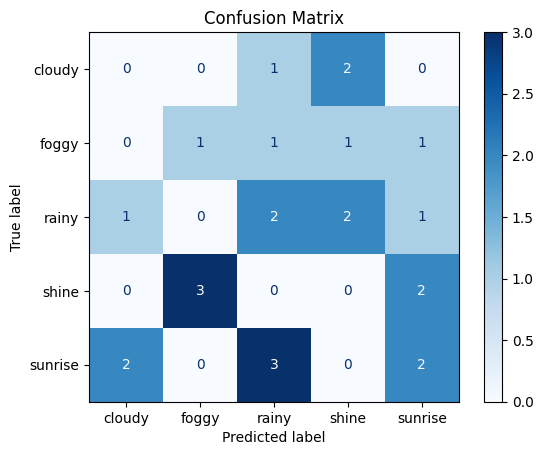

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Get predictions for all images in the test_generator
predictions = model.predict(test_generator)

# Get the predicted classes for all images
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_classes = test_generator.classes

# Calculate accuracy by comparing predicted classes with true labels
accuracy = np.mean(predicted_classes == true_classes)

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

# Create a confusion matrix
cm = confusion_matrix(true_classes, predicted_classes)

# Display the confusion matrix
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=test_generator.class_indices.keys())
cm_display.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()


### Classification Report

In [33]:
from sklearn.metrics import classification_report

# Get predictions for all images in the test_generator
predictions = model.predict(test_generator)

# Get the predicted classes for all images
predicted_classes = np.argmax(predictions, axis=1)

# Get the true labels from the generator
true_classes = test_generator.classes

# Get the class labels (human-readable class names) from the generator
class_labels = list(test_generator.class_indices.keys())

# Calculate accuracy by comparing predicted classes with true labels
accuracy = np.mean(predicted_classes == true_classes)

# Print accuracy
print(f'Accuracy: {accuracy * 100:.2f}%')

# Generate and print the classification report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print("Classification Report:")
print(report)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 334ms/step
Accuracy: 32.00%
Classification Report:
              precision    recall  f1-score   support

      cloudy       0.00      0.00      0.00         3
       foggy       0.50      0.50      0.50         4
       rainy       0.29      0.33      0.31         6
       shine       0.40      0.40      0.40         5
     sunrise       0.33      0.29      0.31         7

    accuracy                           0.32        25
   macro avg       0.30      0.30      0.30        25
weighted avg       0.32      0.32      0.32        25



# Deploying our Model for prototyping

In [1]:
!pip install --upgrade gradio


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.1/18.1 MB 59.2 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.7/318.7 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 84.3 MB/s eta 0:00:00:00:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 126.3/126.3 kB 7.6 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.18
    Uninstalling urllib3-1.26.18:
      Successfully uninstalled urllib3-1.26.18
  Attempting uninstall: tomlkit
    Found existing installation: tomlkit 0.13.2
    Uninstalling tomlkit-0.13.2:
      Successfully uninstalled tomlkit-0.13.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2024.7.1 requires dask==2024.7.1, but you have dask 2024.9.0 which is incompatible.
kfp 2.5.0 requires google-cloud-storage<3,>=2.2.1, but you have goog

In [1]:
import gradio as gr
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Load your saved model
model = load_model('/kaggle/input/vgg16_for_weather/keras/default/1/wp2.h5')  # Ensure correct path to the model file

# Define a function for making predictions
def predict(image):
    # Preprocess the image
    image = load_img(image, target_size=(224, 224))  # Adjust target size if needed
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0) / 255.0  # Rescale the image to [0, 1]
    
    # Output
    predictions = model.predict(image)
    predicted_class = np.argmax(predictions, axis=1)
    return f"Predicted class: {int(predicted_class[0])}"  # Return the predicted class as text

# Create Gradio interface
interface = gr.Interface(fn=predict, inputs="image", outputs="text", title="Image Classifier")

# Launch the interface with a shareable link
interface.launch(server_port=7860)

ModuleNotFoundError: No module named 'gradio'